## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

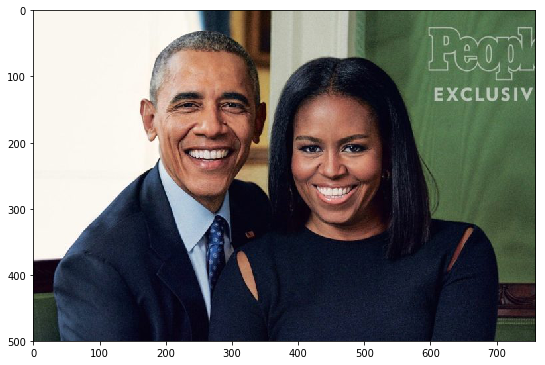

In [3]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


w,h 174 174
w,h 160 160


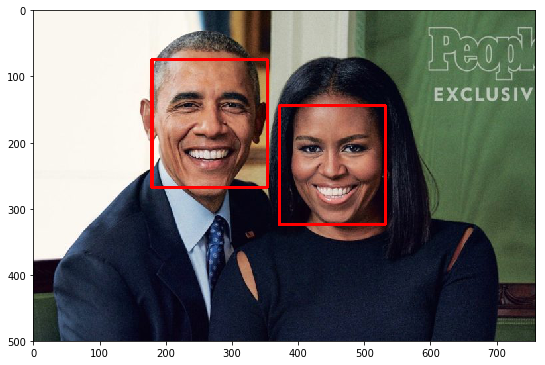

In [4]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h+20),(255,0,0),3) 
    print("w,h",w,h)

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [5]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2)
  (fc1): Linear(in_features=86528, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [51]:
import cv2
import numpy as np
import torch

# modified and reused from previous notebook
class Rescale(object):
    """Rescale the image in a sample to a given size."""

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, input_image):

        h, w = input_image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(input_image, (new_w, new_h))
        return img

# modified and reused from previous notebook
class RandomCrop(object):
    """Crop randomly the image in a sample."""

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, input_image):

        h, w = input_image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        input_image = input_image[top: top + new_h, left: left + new_w]

        return input_image

# modified and reused from previous notebook
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image_input):
        # if image has no grayscale color channel, add one
        if len(image_input.shape) == 2:
            # add that third color dim
            image_input = image_input.reshape(image_input.shape[0], image_input.shape[1], 1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image_input = image_input.transpose((2, 0, 1))

        return torch.from_numpy(image_input)
    
# taken from previous notebook to show predicted facial points
def show_all_keypoints(input_image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(input_image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

# modified  function from previous notebook to show facial key points on one image only
def visualize_output(test_image, test_output, gt_pts=None):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(2, 2, 1)
    # un-transform the image data
    image1 = test_image.data  # get the image from it's Variable wrapper
    image1 = image1.numpy()  # convert to numpy array from a Tensor
#     image1 = np.transpose(test_image, (1, 2, 0))  # transpose to go from torch to numpy image

    # un-transform the predicted key_pts data
    predicted_key_pts = test_output.data
    predicted_key_pts = predicted_key_pts.numpy()
    # undo normalization of keypoints  
    predicted_key_pts = predicted_key_pts * 50.0 + 100

    # plot ground truth points for comparison, if they exist
    ground_truth_pts = None
    if gt_pts is not None:
        ground_truth_pts = gt_pts
        ground_truth_pts = ground_truth_pts * 50.0 + 100

    # call show_all_keypoints
    show_all_keypoints(np.squeeze(image1), predicted_key_pts, ground_truth_pts)

    plt.axis('off')

    plt.show()

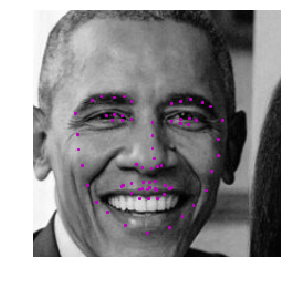

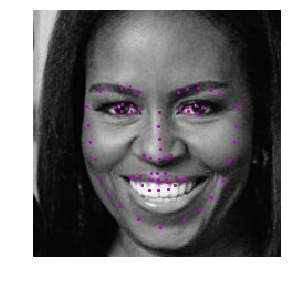

In [54]:
#  work on copied image.
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
  
    # Select the region of interest that is the face in the image with some padding
    roi = image_copy[y-30:y+h+30, x-30:x+w+30]
#     print(roi.shape)
    
    ## TODO: Convert the face region from RGB to grayscale
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    gray_copy= np.copy(gray_roi)
    gray_roi_normalized = gray_copy / 255.0
    
#     print(gray_roi.shape)
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    rescalar=Rescale(250)
    rescaled_image=rescalar(gray_roi_normalized)
#     print(rescaled_image.shape)
    crop = RandomCrop(224)
    cropped_image = crop(rescaled_image)
#     print(cropped_image.shape)
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    
    tensor_image= ToTensor()(cropped_image).unsqueeze(0)
#     print(tensor_image.shape)
    tensor_image = tensor_image.float()
    
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    output_points=net(tensor_image)
    # change  the shape
    output_points=output_points.view(68,-1)
    # plot the points and show the image.
    visualize_output(tensor_image, output_points, gt_pts=None)
        
